# Sentiment Analysis for WittyWicky Inc.

## Introduction

WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.

Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value. As a team of data scientists consulting for WittyWicky Inc., you are now responsible for meeting their business outcomes.

#### Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

### Dataset Description
This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

#### Evaluation Metric
We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

#### Submission format
Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference.

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
#Display all the columns 
pd.set_option('display.max_columns',None)
# Display full length the column
pd.set_option('display.max_colwidth', -1)

In [2]:
# Importing libraries

import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from string import punctuation
from nltk.stem.porter import *
from gensim.models import Word2Vec,KeyedVectors
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score

In [3]:
# Loading Train Data

ctrain = pd.read_csv('../data/raw/train.csv')
ctrain.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


# Data Analysis

In [4]:
# data types of the features

ctrain.dtypes

tweet_id     int64 
tweet        object
sentiment    int64 
dtype: object

In [5]:
# Data distribution of target variable

ctrain['sentiment'].value_counts()

1    4311
2    2382
0    456 
3    125 
Name: sentiment, dtype: int64

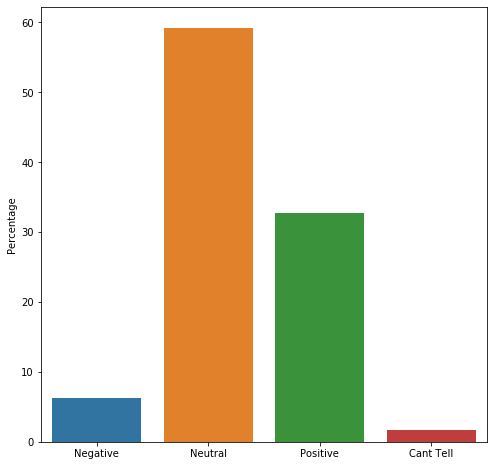

In [6]:
# Plotting distribution of target

fig, ax = plt.subplots(figsize=(8, 8))
counts = ctrain.sentiment.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive', 'Cant Tell'])
ax.set_ylabel("Percentage")
plt.show()

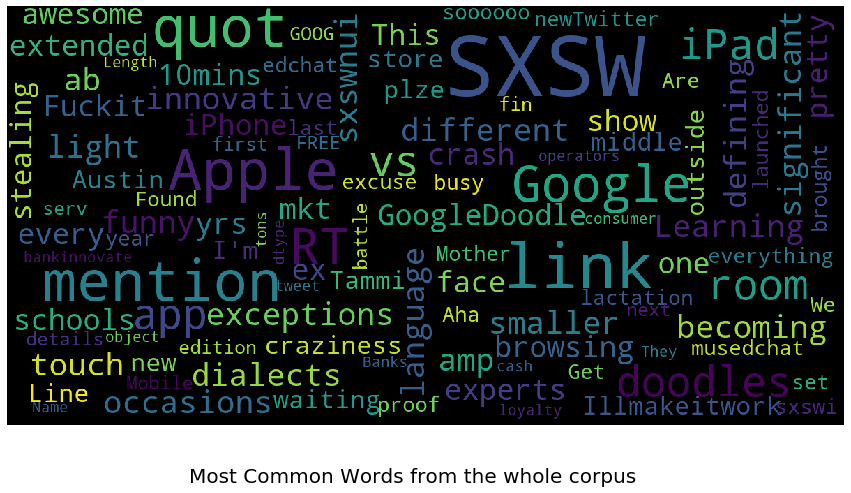

In [7]:
# WordCLoud for most common words

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=10000,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(ctrain['tweet'],'Most Common Words from the whole corpus')

# Data Preprocessing

In [8]:
# Converting tweets to lowercase

ctrain['tweet']  = ctrain['tweet'].str.lower()
ctrain.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1


In [9]:
# Importing HTMLParser
# Used to remove html tags from the tweets

from html.parser import HTMLParser
html = HTMLParser()

In [10]:
# checking for null values

ctrain['tweet'].isna().sum()

1

In [11]:
# Dropping the single null value present in the train dataset

ctrain.dropna(inplace=True)
ctrain.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1


In [12]:
# Created a new columns i.e. tweet_html which do not contain html tags

ctrain['tweet'] = ctrain['tweet'].apply(lambda x: html.unescape(x))
ctrain.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"learning ab google doodles! all doodles should be light, funny & innovative, with exceptions for significant occasions. #googledoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention ""at #sxsw, apple schools the mkt experts"" {link}",2
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1


In [13]:
# Set of emoticons 

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

In [14]:
# function to convert nltk tag to wordnet tag

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [15]:
# Function to tokenize, add pos_tag and lemmatize the tweets

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    nltk_tagged = nltk.pos_tag(tokenizer.tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
          if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
                #tweet = str(TextBlob(word).correct())                
                if tag is None:
                    #if there is no available tag, append the token as is
                    lemmatized_sentence.append(word)
                else:        
                    #else use the tag to lemmatize the token
                    lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)    


In [16]:
# Function to clean regex from tweets

def clean_tweets(tweet):    
    # remove numbers
    tweet = tweet.lower()
    tweet = re.sub(r'\d+', '', tweet)
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^rt[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    return lemmatize_sentence(tweet)

In [17]:
# Applying clean tweets function to clean the tweets column

ctrain['tweet'] = ctrain.apply(lambda row: clean_tweets(str(row['tweet'])), axis=1)
ctrain.head()

,tweet_id,tweet,sentiment
0,1701,sxswnui sxsw apple define language touch different dialect become small,1
1,1851,learn ab google doodle doodle light funny innovative exception significant occasion googledoodle sxsw,1
2,2689,one face ex steal show yrs rt mention sxsw apple school mkt expert link,2
3,4525,iphone sxsw app would b pretty awesome crash every min extended browsing fuckit illmakeitwork,0
4,3604,line outside apple store austin wait new ipad sxsw link,1


In [18]:
# Top 10 most frequent words

most_freq_words = pd.Series(' '.join(ctrain['tweet']).split()).value_counts()[:10]
most_freq_words = list(most_freq_words.index)
print("Most Frequent Words")
print(most_freq_words)


ctrain['tweet'] = ctrain['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in most_freq_words))

ctrain.head()

Most Frequent Words
['sxsw', 'mention', 'link', 'ipad', 'google', 'apple', 'iphone', 'store', 'new', 'rt']


,tweet_id,tweet,sentiment
0,1701,sxswnui define language touch different dialect become small,1
1,1851,learn ab doodle doodle light funny innovative exception significant occasion googledoodle,1
2,2689,one face ex steal show yrs school mkt expert,2
3,4525,app would b pretty awesome crash every min extended browsing fuckit illmakeitwork,0
4,3604,line outside austin wait,1


In [19]:
# Least Frequent Words

least_freq_words = pd.Series(' '.join(ctrain['tweet']).split()).value_counts()[-2994:]
least_freq_words = list(least_freq_words.index)
print("Least Frequent Words")
print(least_freq_words)

ctrain['tweet'] = ctrain['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in least_freq_words))
ctrain.head()

Least Frequent Words
['wayfarer', 'roughly', 'mexican', 'kenya', 'pray', 'sprinkle', 'hustlin', 'cupcake', 'sxsma', 'antwoord', 'foodthought', 'myprototype', 'guidance', 'demos', 'va', 'psychedthough', 'socialgood', 'mktgmoment', 'snag', 'dispenser', 'grounlink', 'malt', 'bringing', 'kickball', 'superlucky', 'jeopardy', 'overwhelm', 'appeal', 'tooo', 'sanders', 'webex', 'responses', 'aproveitem', 'piss', 'tightasstraveler', 'den', 'iphoneography', 'upgrading', 'midway', 'sketchily', 'jqtouch', 'pecan', 'googlekillsit', 'foliot', 'apraxia', 'departure', 'coincides', 'smittys', 'synthetic', 'socailmedia', 'configuration', 'fcc', 'role', 'caramel', 'macworld', 'delivery', 'bday', 'clueless', 'germ', 'ti', 'cartridge', 'crushit', 'tix', 'sweepstakes', 'hassle', 'sxswfail', 'notsurprised', 'quitted', 'docomo', 'coinsidence', 'laurieshook', 'blahzay', 'surprised', 'dumbanddumber', 'aristotle', 'wiiings', 'magnifying', 'couchfan', 'remix', 'stribpol', 'ridic', 'detect', 'kanye', 'rechristenin

,tweet_id,tweet,sentiment
0,1701,sxswnui define touch different become small,1
1,1851,learn ab doodle doodle light funny innovative googledoodle,1
2,2689,one face ex steal show yrs school mkt expert,2
3,4525,app would b pretty awesome crash every min,0
4,3604,line outside austin wait,1


In [20]:
# After cleaning ctrain

ctrain.head()

,tweet_id,tweet,sentiment
0,1701,sxswnui define touch different become small,1
1,1851,learn ab doodle doodle light funny innovative googledoodle,1
2,2689,one face ex steal show yrs school mkt expert,2
3,4525,app would b pretty awesome crash every min,0
4,3604,line outside austin wait,1


# EDA

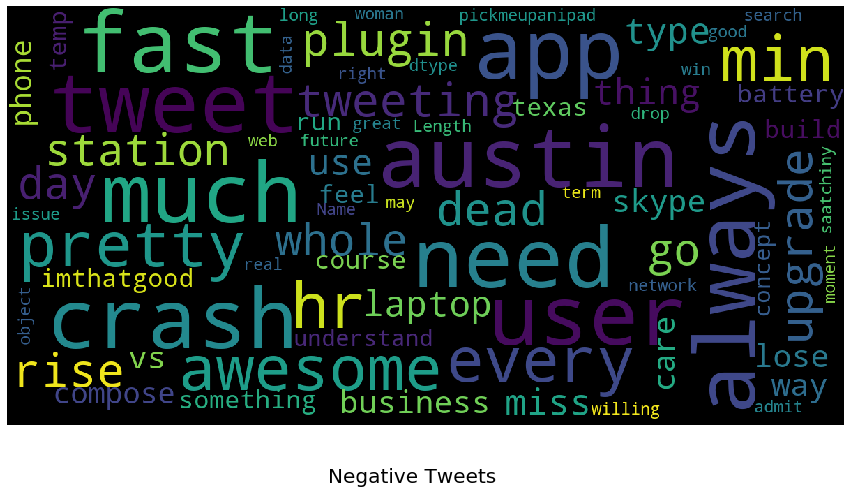

In [21]:
show_wordcloud(ctrain[ctrain['sentiment'] == 0]['tweet'],'Negative Tweets')

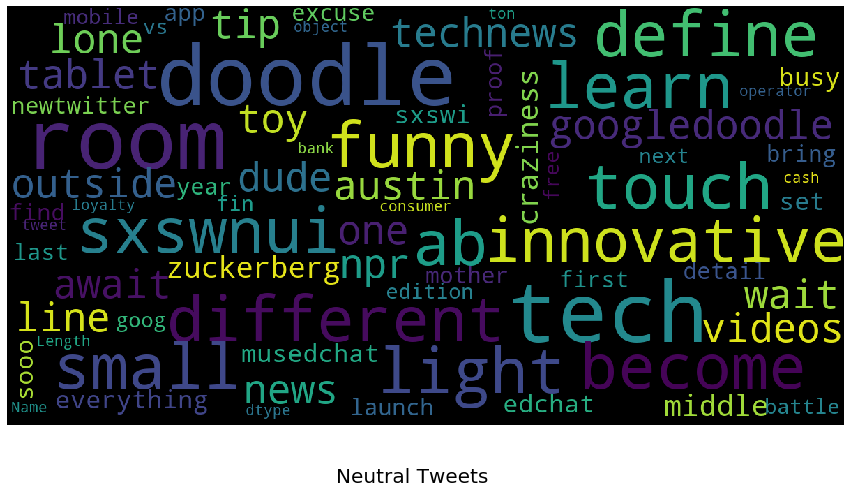

In [22]:
show_wordcloud(ctrain[ctrain['sentiment'] == 1]['tweet'],'Neutral Tweets')

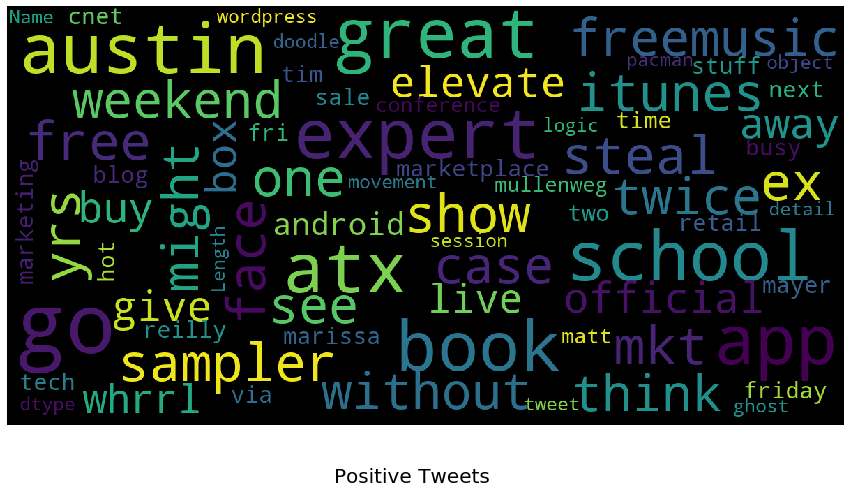

In [23]:
show_wordcloud(ctrain[ctrain['sentiment'] == 2]['tweet'],'Positive Tweets')

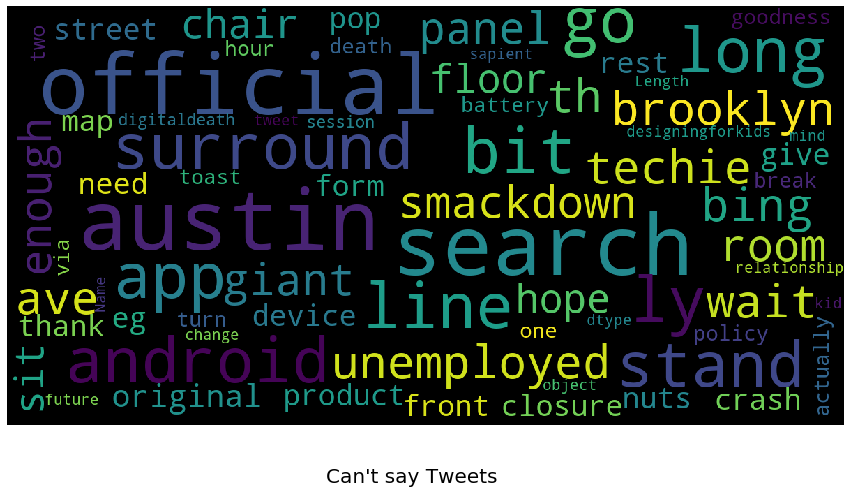

In [24]:
show_wordcloud(ctrain[ctrain['sentiment'] == 3]['tweet'],'Can\'t say Tweets')

# Feature Extraction

In [25]:
# Applying Count Vectorization

bow = CountVectorizer(lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(ctrain['tweet'])
train_bow

<7273x4046 sparse matrix of type '<class 'numpy.int64'>'
	with 52268 stored elements in Compressed Sparse Row format>

In [50]:
cv_dataframe=pd.DataFrame(train_bow.toarray(),columns=bow.get_feature_names())
cv_dataframe.head(10).iloc[:,:10]

,aapl,aaron,aarpbulletin,ab,abacus,abba,abc,ability,able,absolutely
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [26]:
# Applying TF-IDF Vectorization

tfidf = TfidfVectorizer(lowercase=True, analyzer='word', stop_words= 'english', ngram_range=(1,1))
train_tfidf = tfidf.fit_transform(ctrain['tweet'])
train_tfidf

<7273x3911 sparse matrix of type '<class 'numpy.float64'>'
	with 46342 stored elements in Compressed Sparse Row format>

In [27]:
# Splitting into features and targets 

from sklearn.model_selection import train_test_split  

X = train_bow
y = ctrain['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


# Models

In [28]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
print(confusion_matrix(y_test,y_pred_lr))  
print(classification_report(y_test,y_pred_lr))  
print(accuracy_score(y_test, y_pred_lr))
print(f1_score(y_test, y_pred_lr,average='weighted'))

[[  36   82   25    1]
 [  19 1031  214    5]
 [  10  347  373    5]
 [   1   27    6    0]]
              precision    recall  f1-score   support

           0       0.55      0.25      0.34       144
           1       0.69      0.81      0.75      1269
           2       0.60      0.51      0.55       735
           3       0.00      0.00      0.00        34

    accuracy                           0.66      2182
   macro avg       0.46      0.39      0.41      2182
weighted avg       0.64      0.66      0.64      2182

0.6599450045829515
0.6434803702327218


In [29]:
# Naive Bayes Multinomial Model

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
 
print(confusion_matrix(y_test,y_pred_nb))  
print(classification_report(y_test,y_pred_nb))  
print(accuracy_score(y_test, y_pred_nb))
print(f1_score(y_test, y_pred_nb,average='weighted'))

[[ 33  71  39   1]
 [ 38 955 270   6]
 [ 18 320 394   3]
 [  0  25   9   0]]
              precision    recall  f1-score   support

           0       0.37      0.23      0.28       144
           1       0.70      0.75      0.72      1269
           2       0.55      0.54      0.54       735
           3       0.00      0.00      0.00        34

    accuracy                           0.63      2182
   macro avg       0.41      0.38      0.39      2182
weighted avg       0.62      0.63      0.62      2182

0.6333638863428047
0.622893943446105


# Test

In [30]:
# Importing Test.csv

test = pd.read_csv('../data/raw/test.csv')
test.head()

,tweet_id,tweet
0,7506,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw"
1,7992,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone
2,247,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,7688,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,3294,#SXSW Google maps is even cooler than I thought


In [31]:
# Making copy of test

ctest = test.copy()
ctest.head()

,tweet_id,tweet
0,7506,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw"
1,7992,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone
2,247,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,7688,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,3294,#SXSW Google maps is even cooler than I thought


In [32]:
# Converting tweets to lowercase

ctest['tweet']  = ctest['tweet'].str.lower()
ctest.head()

,tweet_id,tweet
0,7506,"audience q: what prototyping tools do you use? sketchbooks/sharpie pens, photoshop, balsamic, google docs, axsure, etc. #myprototype #sxsw"
1,7992,at sxsw? send your best photos &amp; videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #cyber #iphone
2,247,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,7688,google marissa mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,3294,#sxsw google maps is even cooler than i thought


In [33]:
# Preprocessing Test data

ctest['tweet'] = ctest['tweet'].apply(lambda x: html.unescape(x))
ctest.head()

,tweet_id,tweet
0,7506,"audience q: what prototyping tools do you use? sketchbooks/sharpie pens, photoshop, balsamic, google docs, axsure, etc. #myprototype #sxsw"
1,7992,at sxsw? send your best photos & videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #cyber #iphone
2,247,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,7688,google marissa mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,3294,#sxsw google maps is even cooler than i thought


In [34]:
# Cleaning test data

ctest['tweet'] = ctest.apply(lambda row: clean_tweets(str(row['tweet'])), axis=1)
ctest.head()

,tweet_id,tweet
0,7506,audience q prototyping tool use sketchbook sharpie pen photoshop balsamic google doc axsure etc myprototype sxsw
1,7992,sxsw send best photo video link citizen journalism cnn ireport photography sxsw cyber iphone
2,247,mention pic win ipad unsix sxsw cc mention mention link cont link
3,7688,google marissa mayer mobile phone cursor physical location new version map fast real life like sxsw
4,3294,sxsw google map even cool think


In [35]:
# Transforming test data with CV

test_bow = bow.transform(ctest['tweet'])

In [36]:
# Logistic Regression on Test Data

lr = LogisticRegression()
lr.fit(X,y)
y_pred_lr_test = pd.Series(lr.predict(test_bow))
y_pred_lr_test

0       1
1       1
2       1
3       2
4       2
       ..
1814    1
1815    1
1816    1
1817    1
1818    1
Length: 1819, dtype: int64

In [37]:
# Naive Bayes Multinomial 

nb = MultinomialNB()
nb.fit(X,y)
y_pred_nb_test = pd.Series(nb.predict(test_bow))
y_pred_nb_test

0       1
1       1
2       1
3       2
4       2
       ..
1814    1
1815    1
1816    1
1817    1
1818    1
Length: 1819, dtype: int64

In [38]:
lr_pred_df = pd.concat([test['tweet_id'],y_pred_lr_test],axis=1).set_index('tweet_id')
lr_pred_df.columns = ['sentiment']
lr_pred_df

,sentiment
tweet_id,
7506,1
7992,1
247,1
7688,2
3294,2
...,...
1550,1
1933,1
9052,1


In [39]:
nb_pred_df = pd.concat([test['tweet_id'],y_pred_nb_test],axis=1).set_index('tweet_id')
nb_pred_df.columns = ['sentiment']
nb_pred_df

,sentiment
tweet_id,
7506,1
7992,1
247,1
7688,2
3294,2
...,...
1550,1
1933,1
9052,1


In [40]:
# CSV files of Logistic predictions

# lr_pred_df.to_csv(r'C:\Data Science\Jupyter Notebook\GitHackathon\result_submissions\lr_pred_31_05.csv')

In [41]:
# CSV files of Multinomial predictions

# nb_pred_df.to_csv(r'C:\Data Science\Jupyter Notebook\GitHackathon\result_submissions\nb_pred_31_05.csv')

In [43]:
lr_pred_df['sentiment'].value_counts()

1    1266
2    506 
0    46  
3    1   
Name: sentiment, dtype: int64